In [1]:
!pip install --upgrade tf_slim

import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tf_slim as slim
import numpy.random as rnd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque # container em forma de lista, com rapida insercao e remocao nas duas extremidades 
from ns3gym import ns3env

#from sklearn.preprocessing import label_binarize
#from keras.layers import Dense, Flatten, Reshape

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('ns3-v0') # environment ID 

# numero de estados
state_size = env.observation_space.shape[0]

# numero de acoes
action_size = env.action_space.n

print("\n")
print("Numero de Estados: ", state_size)
print("Numero de Acoes: ", action_size) 

Got new port for ns3gm interface:  5913


Numero de Estados:  4
Numero de Acoes:  4


In [4]:
numOfEpisodes = 200
numTimeSlots = 495

discount_rate = 0.618 # gamma 0.618; 0.528
learning_rate = 0.7 # Learning rate 0.7

# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 128 # tamanho do batch 128

MIN_REPLAY_SIZE = 1000 # tamanho minimo da memoria de repeticao


In [5]:
def createModel(state_size, action_size, loss='mse'):
    learning_rate = 0.01
    init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    # Input layer - número dos estados de entrada 
    model.add(keras.layers.Dense(state_size, input_shape=(state_size,), activation='relu', kernel_initializer=init))
    # Output layer - número de ações no ambiente
    model.add(keras.layers.Dense(action_size, activation='linear', kernel_initializer=init))
    #model.add(keras.layers.Flatten())
    
    if(loss=='huber'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
        print('Using Huber loss...', "\n")
    elif(loss=='mse'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
        print('Using MSE loss...', "\n")
    else:
        print('Loss not defined...', "\n")
    return model

def train(replay_memory, model, model_target, collisionCnt, batch_size, acc_history=[], loss_history=[]):
    mini_batch = random.sample(replay_memory, batch_size)
    c_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list  = model.predict(c_states)
    n_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = model_target.predict(n_states)

    X = []
    Y = []
    for index, (c_state, action, reward, n_state, collisionCnt) in enumerate(mini_batch):
        #  collisionCnt != maxNofCollisions
        # done = not True  Nao atingiu o limite de Collisions = 3
        if not done:
            max_future_q = reward + discount_rate * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = max_future_q

        X.append(c_state)
        Y.append(current_qs)

    # Train model with a mini-batch.
    history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

    # Store metrics.
    acc_history.append(history.history['acc'][0])
    loss_history.append(history.history['loss'][0])

    return history

In [6]:
print("Prediction Network")
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(state_size, action_size)

print("Target Network")
# Build a target model for the prediction of future rewards.
model_target = createModel(state_size, action_size)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Prediction Network
Using MSE loss... 

Target Network
Using MSE loss... 



In [7]:
model.metrics_names

['loss', 'acc']

In [8]:
acc_history = []
loss_history = []

episode_reward = np.zeros((numOfEpisodes,))
max_reward =  np.zeros((numOfEpisodes,))
replay_memory = deque(maxlen=50_000)

steps_to_update_target_model = 0


for episode in range(numOfEpisodes):
    
        
    print('Episode:', episode)

    collisionCnt = 0
    
    state = env.reset()
    #state = np.reshape(state, [1, state_size])
    state = np.array(state)
    
                       
    for iteration in range(numTimeSlots):
        
                        
        steps_to_update_target_model += 1
        
        print("Time Slot   :", iteration)
        print("----------------------")
        
        print("Estado atual:", state)
                  
        # Escolha da ação.
        if np.random.uniform() >= epsilon:
            predicted = model.predict(state.reshape(1,4))
            action = np.argmax(predicted[0])
            print("Action (Q):", action)
        else:
            action = np.random.randint(0, state_size)
            print("Action (rnd):", action)
            
        next_state, reward, done, _ = env.step(action)
      
        #next_state = np.reshape(next_state, [1, state_size])
        next_state = np.array(next_state)
        print("Next State:", next_state)
        
        if reward == -1:
            collisionCnt += 1

        # Add information to replay buffer.
        replay_memory.append([state, action, reward, next_state, collisionCnt])          

        # Accumulate reward.
        episode_reward[episode] += reward
      
        # Plot received reward.
        print("Reward      :", reward)
        print("-------------", "\n")      

        # Train
        if len(replay_memory) >= MIN_REPLAY_SIZE:
            history = train(replay_memory, model, model_target, collisionCnt, batch_size, acc_history, loss_history)

        # Is it the end of the episode?
        # if(collisionCnt == maxNofCollisions)
        # done == True atingiu o limite de Collisions = 3
        if done:
            # Update the the target network with new weights
            model_target.set_weights(model.get_weights())
            collisionCnt = 0
            print('########## Game Over ##########')
            break
        
        # updates the current state
        state = next_state
        
    # Decrease epsilon along the way.
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    epsilon_vec[episode] = epsilon 
        
    # Store maxmim possible reward per episode.
    max_reward[episode] = iteration + 1              
        
    print('episode_reward:', episode_reward[episode])

Episode: 0
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estad

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 2.0
Episode: 5
Got new port for ns3gm interface:  6144
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next S

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 0.0
Episode: 23
Got new port for ns3gm interface:  6806
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
E

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episo

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode: 61
Got

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode: 76
Got

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode: 82
G

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode: 90
Got

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [

Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
-----

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 3.0
Episode: 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atua

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado at

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual:

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado a

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]


Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_rewa

Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
-----

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: 

Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 1 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 1 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next S

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]


Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 163
----------------------
Estado 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado a

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado 


Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 135
----------------------
Estado

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 210
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 211
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 212
----------------------
Estado 

Time Slot   : 284
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 285
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 286
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 287
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 288
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 289
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 290
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 291
----------------------
Estado atual

Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 363
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 364
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 365
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 366
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 367
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 368
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 369
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
-------------

########## Game Over ##########
episode_reward: 371.0
Episode: 123
Got new port for ns3gm interface:  5869
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0

----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Es

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0

Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
-------------

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual: 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
A

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 77
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]


Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1

Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 


Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
-------------

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado 

Time Slot   : 289
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 290
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 291
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 292
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 293
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 294
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 295
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 296
----------------------
Estado a

Time Slot   : 371
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 372
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 373
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 374
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 375
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 376
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 377
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 378
----------------------
Estado at

Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 448
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 449
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 450
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 451
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 452
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 453
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 454
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual

Time Slot   : 199
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 126
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 127
----------------------
Estado atua

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 179
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado a

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
--------

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atua

Time Slot   : 231
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 232
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 233
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 234
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 235
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 236
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 237
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 238
----------------------
Estado atual

Time Slot   : 319
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 320
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 321
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 322
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 323
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 324
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 325
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 326
----------------------
Estado at

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 406
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 407
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 408
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 409
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 410
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 411
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 412
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
-------------

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 124
----------------------
Estado a

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: 

----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
A

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
A

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
-----

Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
---

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 125
----------------------
Estado atua

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 97
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
----------------------
Estado atu

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]


Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0

----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action

Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado at

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0

Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
--------

Time Slot   : 238
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 239
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 240
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 241
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 242
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 243
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual

Time Slot   : 325
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 326
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 327
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 328
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 329
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 330
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 331
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 332
----------------------
Estado atual

Time Slot   : 413
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 414
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 415
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 416
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 417
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 418
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 419
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 420
----------------------
Estado atual

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Estado at

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 248
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 249
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 250
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 251
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 252
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 253
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 254
----------------------
Estado 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 195
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 197
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 198
----------------------
Estado atu

Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 276
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 277
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 280
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 281
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 282
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado at

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 1 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 1 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: 

Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 273
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 274
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 275
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 276
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 277
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0

########## Game Over ##########
episode_reward: 311.0
Episode: 155
Got new port for ns3gm interface:  9609
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward 

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

T

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Esta

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
-

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 1 1 0]
Reward      : -1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 1 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
----

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 123
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 124
----------------------
Estado atu

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 209
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 210
----------------------
Estado a

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 289
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 290
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 291
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 292
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 293
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 294
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 295
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
--------

Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 376
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 377
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 378
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 379
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 380
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 381
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 382
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward     

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado at

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward

Time Slot   : 78
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 85
----------------------
Estado atual

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 159
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 160
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 161
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual

Time Slot   : 241
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 242
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 243
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 246
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 248
----------------------
Estado a

Time Slot   : 320
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 321
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 322
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 323
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 324
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 325
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 326
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 327
----------------------
Estado atual

------------- 

Time Slot   : 401
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 402
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 403
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 404
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 405
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 406
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 407
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 408
---------------

Time Slot   : 480
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 481
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 482
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 483
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 484
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 485
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 486
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 487
----------------------
Estado atual: 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 141
----------------------
Estado 

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 213
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 214
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 215
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 216
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 217
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 218
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 219
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1

Time Slot   : 286
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 287
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 288
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 289
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 290
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 291
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 292
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 293
----------------------
Estado atual: 

----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
N

Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
---

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 118
----------------------
Estado atua

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 195
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 197
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 198
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 199
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 200
----------------------
Estado atual

Time Slot   : 272
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 273
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 274
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 275
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 276
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 277
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: 

Time Slot   : 352
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 353
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 354
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 355
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 356
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 357
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 358
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 359
----------------------
Estado atual: 

Time Slot   : 435
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 436
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 437
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 438
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 439
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 440
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 441
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 442
----------------------
Estado atual

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Time Slot   : 79
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 80
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 81
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 82
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 83
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atua

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 1 1 0]
Reward      : 1.0
------------- 

Time Slot   : 190
----------------------
Estado atual: [0 1 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 191
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 192
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 193
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 194
----------------------
Estado atual: 

Time Slot   : 272
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 273
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 274
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 275
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 276
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 277
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 279
----------------------
Estado at

Time Slot   : 356
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 357
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 358
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 359
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 360
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 361
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 362
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 363
----------------------
Estado atual: 

Time Slot   : 442
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 443
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 444
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 445
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 446
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 447
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 448
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 449
----------------------
Estado a

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atu

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
-----

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 122
----------------------
Estado atu

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 203
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 204
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 205
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 206
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 207
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 208
----------------------
Estado atual: 

Time Slot   : 280
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 281
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 282
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 283
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 284
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 285
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 286
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 287
----------------------
Estado atual

----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 361
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 362
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 363
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 364
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 365
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 366
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 367
----------------------
Estado atual: [0 0 0 1

Time Slot   : 441
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 442
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 443
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 444
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 445
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 446
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 447
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 448
----------------------
Estado atual: 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 118
----------------------
Estado atua

Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 196
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 197
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 198
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 199
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 200
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 201
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 202
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
-

Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 280
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 281
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 282
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 283
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 284
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
-

Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 364
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 365
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 366
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 367
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 368
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 369
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 370
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 


Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 56.0
Episode: 175
Got new port for ns3gm interface:  7171
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atual: 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 118
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 119
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 120
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 121
----------------------
Estado 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
----

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 179
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 182
----------------------
Estado atual: 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual

Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 228
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 229
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 230
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 231
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 232
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 233
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 234
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 

Time Slot   : 315
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 316
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 317
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 318
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 319
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 320
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 321
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 322
----------------------
Estado atual: 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 

Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 179
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 180
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 181
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [

Time Slot   : 259
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 260
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 261
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 262
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 263
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 264
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 265
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 266
----------------------
Estado at

Time Slot   : 343
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 344
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 345
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 346
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 347
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 348
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 349
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 350
----------------------
Estado atual: 

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 426
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 427
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 428
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 429
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 430
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 431
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 432
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 158
----------------------
Estado atual: 

Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 231
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 232
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 233
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 234
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 235
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 236
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 237
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0

Reward      : 1.0
------------- 

Time Slot   : 312
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 313
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 314
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 315
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 316
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 317
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 318
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 319
---

Time Slot   : 398
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 399
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 400
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 401
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 402
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 403
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 404
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 405
----------------------
Estado atual

Time Slot   : 478
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 479
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 480
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 481
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 482
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 483
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 484
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 485
----------------------
Estado atu

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
----------

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atu

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 262
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 263
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 264
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 265
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 266
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 267
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 268
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 


Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 54
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0

Time Slot   : 127
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 128
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 129
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 130
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atu

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 36
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 37
----------------------
Estado atual: [0 1 0

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 102
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0

Time Slot   : 162
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 163
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 167
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 168
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 169
----------------------
Estado at

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual

Time Slot   : 214
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 215
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 216
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 217
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 218
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 219
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 220
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 221
----------------------
Estado atu

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 278
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 279
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 280
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 281
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 282
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 283
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 284
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
-------------

Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 97
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 101
----------------------
Estado atual: [0 1 0

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 167
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 168
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 169
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atu

Time Slot   : 241
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 242
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 243
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 246
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 248
----------------------
Estado atual

Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 309
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 310
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 311
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 312
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 313
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 314
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 315
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
-

Time Slot   : 381
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 382
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 383
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 384
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 385
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 386
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 387
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 388
----------------------
Estado atual: 

----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 55
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
N

Time Slot   : 131
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 132
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 15
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 16
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: 

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 221
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 222
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 223
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 224
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 225
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 226
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 227
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
-----------

Reward      : 1.0
------------- 

Time Slot   : 298
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 299
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 300
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 301
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 302
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 303
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 304
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 305

Time Slot   : 380
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 381
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 382
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 383
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 384
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 385
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 386
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 387
----------------------
Estado atual

Time Slot   : 457
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 458
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 459
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 460
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 461
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 462
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 463
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 464
----------------------
Estado atual

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 35
----------------------
Estado atual: [0 0

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atua

Time Slot   : 182
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 183
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 184
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 185
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 186
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 187
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 188
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 189
----------------------
Estado atual

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 

Time Slot   : 164
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 165
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 166
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 167
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 168
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 169
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 246
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 248
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 249
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 250
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 251
----------------------
Estado atua

Time Slot   : 326
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 327
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 328
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 329
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 330
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 331
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 332
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 333
----------------------
Estado at

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 409
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 410
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 411
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 412
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 413
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 414
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 415
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
-------------

Time Slot   : 486
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 487
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 488
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 489
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 490
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 491
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 492
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 493
----------------------
Estado a

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 147
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 148
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 149
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 150
----------------------
Estado atual

Time Slot   : 228
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 229
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 230
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 231
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 232
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 233
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 234
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 235
----------------------
Estado atual: 

Time Slot   : 305
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 306
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 307
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 308
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 309
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 310
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 311
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 312
----------------------
Estado atual: 

Time Slot   : 389
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 390
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 391
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 392
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 393
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 394
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 395
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 396
----------------------
Estado atual

Time Slot   : 475
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 476
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 477
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 478
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 479
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 480
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 481
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 482
----------------------
Estado atua

Time Slot   : 56
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1

Time Slot   : 133
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 134
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: 

Time Slot   : 213
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 214
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 215
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 216
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 217
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 218
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 219
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 220
----------------------
Estado atual: 

Time Slot   : 57
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0

Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 142
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 143
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 144
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 145
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 146
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 


Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 223
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 224
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 225
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 226
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 227
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 228
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 229
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------

Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
----

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 104
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 105
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 106
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 107
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 178
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 179
----------------------
Estado atual

Time Slot   : 243
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 244
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 245
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 246
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 247
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 248
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 249
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 250
----------------------
Estado atual: 

Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 323
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 324
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 325
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 326
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 327
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 328
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 329
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
----------

Time Slot   : 406
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 407
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 408
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 409
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 410
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 411
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 412
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 413
----------------------
Estado atual

Reward      : 1.0
------------- 

Time Slot   : 491
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 492
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 493
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 494
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

episode_reward: 455.0
Episode: 197
Got new port for ns3gm interface:  6193
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next S

Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 75
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 76
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
--------

Time Slot   : 150
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 151
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 152
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 153
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 154
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 155
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 156
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 157
----------------------
Estad

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 

Time Slot   : 170
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 171
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 172
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 173
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 174
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 175
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 176
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 177
----------------------
Estado atu

------------- 

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Esta

Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 135
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 136
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 137
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 138
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 139
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 140
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 141
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
-

Time Slot   : 211
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 212
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 213
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 214
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 215
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 216
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 217
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 218
----------------------
Estado atual

In [9]:
from sklearn.preprocessing import label_binarize
state = label_binarize([0, 1, 2, 3], classes=[0, 1, 2, 3])

In [10]:
for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.4491277  0.55147266 2.541509   2.544933  ]
-----

Estado atual: [0 1 0 0]
Q: [2.529068  2.470024  0.5754663 2.533994 ]
-----

Estado atual: [0 0 1 0]
Q: [2.5354452  2.4759903  2.5295277  0.62245584]
-----

Estado atual: [0 0 0 1]
Q: [0.58535814 2.4878035  2.5389895  2.5308125 ]
-----



In [11]:
for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model_target.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.4491277  0.55147266 2.541509   2.544933  ]
-----

Estado atual: [0 1 0 0]
Q: [2.529068  2.470024  0.5754663 2.533994 ]
-----

Estado atual: [0 0 1 0]
Q: [2.5354452  2.4759903  2.5295277  0.62245584]
-----

Estado atual: [0 0 0 1]
Q: [0.58535814 2.4878035  2.5389895  2.5308125 ]
-----



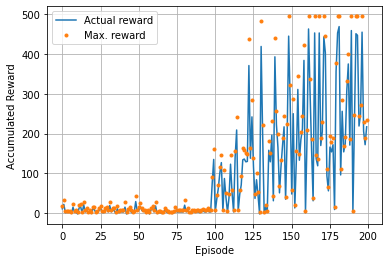

In [12]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

In [13]:
max_reward

array([ 17.,  32.,   5.,   6.,   6.,   6.,   3.,  23.,   6.,   7.,   2.,
        21.,  24.,   4.,  29.,   7.,  13.,   4.,   7.,   3.,  16.,  15.,
         4.,   6.,  13.,  18.,   6.,   5.,  14.,  16.,   7.,  29.,   7.,
        14.,  12.,   3.,  19.,   5.,   8.,   7.,   7.,  27.,   2.,  11.,
        16.,   7.,   4.,   5.,  43.,   9.,  16.,  25.,  13.,   8.,   9.,
         3.,   9.,   2.,  14.,  19.,   7.,  28.,   3.,   5.,   6.,   3.,
         4.,  14.,   7.,   5.,   4.,   4.,   3.,   5.,  15.,   7.,   7.,
         7.,   7.,   7.,  32.,   7.,  13.,   4.,   3.,   7.,   8.,   6.,
         7.,   7.,   5.,   7.,  11.,   7.,   7.,  13.,   7.,   7.,  90.,
       161.,   7.,  45.,  70., 117., 145.,   9., 109.,  50.,   6.,  47.,
       147.,  57.,   7., 156., 241.,   9.,  59.,  93., 164., 158., 151.,
       148., 439., 164., 284., 139.,  49., 102.,  52.,   2., 483., 221.,
         3.,  21.,   6., 182., 151., 232.,  43., 441., 257., 199.,  67.,
       133., 190., 245.,  41., 225., 495., 321.,  5

In [14]:
episode_reward

array([ 11.,  22.,   1.,   2.,   2.,   2.,  -1.,  15.,   2.,   3.,  -2.,
        13.,  16.,   0.,  21.,   3.,   7.,   0.,   3.,  -1.,  10.,   9.,
         0.,   2.,   7.,  12.,   2.,   1.,   8.,  10.,   3.,  19.,   3.,
         8.,   6.,  -1.,  11.,   1.,   4.,   3.,   3.,  15.,  -2.,   5.,
         8.,   3.,   0.,   1.,  29.,   5.,   8.,  17.,   7.,   4.,   5.,
        -1.,   5.,  -2.,   8.,  13.,   3.,  18.,  -1.,   1.,   2.,  -1.,
         0.,   8.,   3.,   1.,   0.,   0.,  -1.,   1.,   7.,   3.,   3.,
         3.,   3.,   3.,  20.,   3.,   7.,   0.,  -1.,   3.,   4.,   2.,
         3.,   3.,   1.,   3.,   5.,   3.,   3.,   7.,   3.,   3.,  74.,
       135.,   3.,  35.,  62., 101., 127.,   5.,  87.,  40.,   2.,  39.,
       123.,  51.,   3., 140., 209.,   5.,  47.,  71., 134., 136., 129.,
       130., 371., 138., 242., 117.,  37.,  84.,  44.,  -2., 419., 197.,
        -1.,  15.,   2., 158., 129., 196.,  31., 393., 223., 165.,  51.,
       117., 170., 217.,  35., 189., 445., 281.,  4

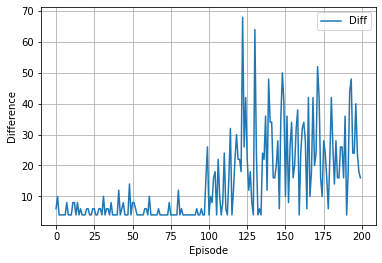

In [15]:
diff  = (max_reward - episode_reward)
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

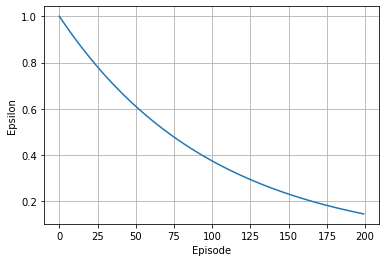

In [16]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

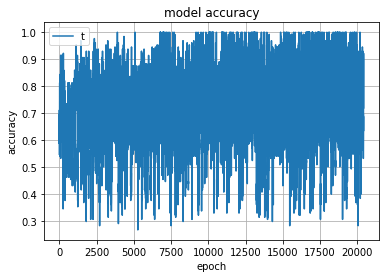

In [17]:
# summarize history for accuracy
plt.plot(acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()

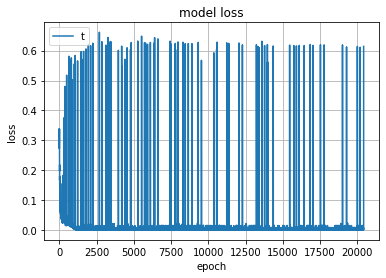

In [18]:
# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()